# Part 1: Generate Data

In [2]:
import numpy as np
import matplotlib.pyplot as plt

dimension_count = 2
centers_sd = 3
centers_count = 10
centers_mean = 0
centers_covariance = np.eye(dimension_count) * centers_sd
samples_sd = 0.5

np.random.seed(8067)

# generate random centers
centers0 = np.random.normal(loc=centers_mean, scale=centers_sd, size=(centers_count, dimension_count))
centers1 = np.random.normal(loc=centers_mean, scale=centers_sd, size=(centers_count, dimension_count))

In [4]:
def generate_samples():
    centers_indices = np.arange(centers_count)
    train_size = 100
    test_size = 5000
    sample_size = train_size + test_size
    samples_covariance = np.eye(dimension_count) * samples_sd
    
    selected_centers0 = np.random.choice(centers_indices, size=sample_size) # select random centers
    samples0 = np.zeros((sample_size, dimension_count + 1))
    for index, center in enumerate(centers0[selected_centers0]):
        sample = np.random.multivariate_normal(mean=center, cov=samples_covariance)
        samples0[index] = np.append(sample, 0) # add response variable

    selected_centers1 = np.random.choice(centers_indices, size=sample_size) # select random centers
    samples1 = np.zeros((sample_size, dimension_count + 1))
    for index, center in enumerate(centers1[selected_centers0]):
        sample = np.random.multivariate_normal(mean=center, cov=samples_covariance)
        samples1[index] = np.append(sample, 1) # add response variable

    train_samples = np.concatenate([samples0[:train_size], samples1[:train_size]])
    np.random.shuffle(train_samples)
    
    test_samples = np.concatenate([samples0[train_size:], samples1[train_size:]])
    np.random.shuffle(test_samples)

    return train_samples, test_samples

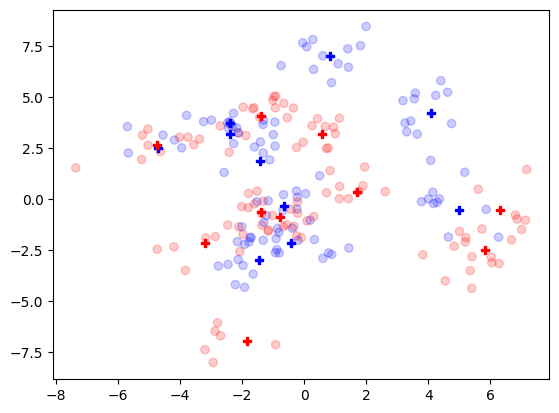

In [8]:
train_samples, test_samples = generate_samples()

# class 0 is blue, class 1 is red
colors = ["blue" if sample[2] == 0 else "red" for sample in train_samples]
plt.scatter(train_samples[:, 0], train_samples[:, 1], c=colors, alpha=0.2)

plt.scatter(centers0[:, 0], centers0[:, 1], c="blue", marker="P")
plt.scatter(centers1[:, 0], centers1[:, 1], c="red", marker="P")

# Part 2: kNN

In [64]:
from scipy.stats import mode

def kNN(train, test, k):
    # sum of squares of test and sum them (P^2)
    test_square = np.sum(test[:, :2]**2, axis=1, keepdims=True)

    # sum of squares of train and sum them (Q^2)
    train_square = np.sum(train[:, :2]**2, axis=1)

    # Train and Test(complement) multiplication, to be (P*Q.T)
    test_dot_train = test[:,:2] @ train[:, :2].T

    # Vectorized Fomula for Computing Distances (P^2 + Q^2 - 2*P*Q)
    dists = np.sqrt(test_square + train_square - 2 * test_dot_train)

    # argsort to sort distances individually
    sorted_indices = np.argsort(dists, axis=1)

    # Get the k smallest distances
    closest_points_indices = sorted_indices[:, :k]
    closest_points_class = train[closest_points_indices][:, :, 2]

    predictions = np.sum(closest_points_class, axis=1) > (k / 2)

    return predictions

## Implementation

#### Vectorization

Euclidian distance for 2-dimensional vectors $x$ and $y$ is $\sqrt{(x_1 - y_1)^2 + (x_2 - y_2)^2}$. This can be broken down to:

$$
\sqrt{x_1^2 - 2x_1y_1 + y_1^2 + x_2^2 - 2x_2y_2 + y_2^2}
$$
$$
\sqrt{(x_1^2 + x_2^2) + (y_1^2 + y_2^2) - 2(x_1y_1 + x_2y_2)}
$$

We then square and sum the rows of the train and test datasets to get the first two terms ($x_1^2 + x_2^2$ and $y_1^2 + y_2^2$). Get the dot product between the two to get the third term ($x_1y_1 + x_2y_2$). Finally, we use broadcasting to get the sum.

#### Distances Ties

From Numpy documentation for `argsort`:

When a is an array with fields defined, this argument specifies which fields to compare first, second, etc. A single field can be specified as a string, and not all fields need be specified, but unspecified fields will still be used, in the order in which they come up in the dtype, to break ties.

So precedent is given to training entry with lower index, which is random since we shuffled the dataset.

#### Voting Ties

If equal number of votes, then precedent is given to the `0` class

In [17]:
np.sum(test_samples[:5]**2, axis=1, keepdims=True)

array([[15.7260362 ],
       [ 5.16828104],
       [26.06290536],
       [13.14229649],
       [44.58841177]])

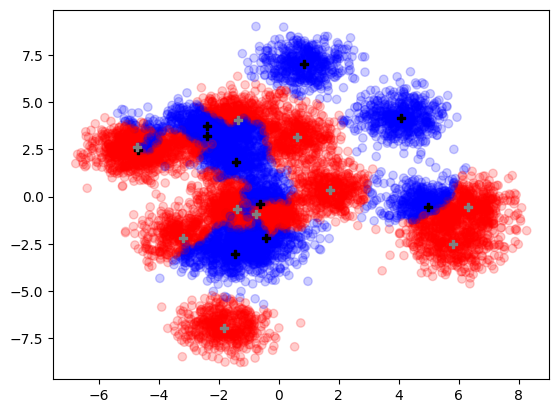

In [65]:
predictions = kNN(train_samples, test_samples, 5)

colors = ["red" if prediction else "blue" for prediction in predictions]
plt.scatter(test_samples[:, 0], test_samples[:, 1], alpha=0.2, c=colors)

# # class 0 centers are black, class 1 centers are gray
plt.scatter(centers0[:, 0], centers0[:, 1], c="black", marker="P")
plt.scatter(centers1[:, 0], centers1[:, 1], c="gray", marker="P")

In [66]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

In [67]:
print("1-NN Confusion Matrices (top is own implementation, bottom is sklearn)")

predictions_self = kNN(train_samples, test_samples, 1)
print(confusion_matrix(test_samples[:, 2], predictions_self))

neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(train_samples[:, :2], train_samples[:, 2])
predictions_sklearn = neigh.predict(test_samples[:, :2])
print(confusion_matrix(test_samples[:, 2], predictions_sklearn))

print("3-NN Confusion Matrices (top is own implementation, bottom is sklearn)")

predictions_self = kNN(train_samples, test_samples, 3)
print(confusion_matrix(test_samples[:, 2], predictions_self))

neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(train_samples[:, :2], train_samples[:, 2])
predictions_sklearn = neigh.predict(test_samples[:, :2])
print(confusion_matrix(test_samples[:, 2], predictions_sklearn))

print("5-NN Confusion Matrices (top is own implementation, bottom is sklearn)")

predictions_self = kNN(train_samples, test_samples, 5)
print(confusion_matrix(test_samples[:, 2], predictions_self))

neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(train_samples[:, :2], train_samples[:, 2])
predictions_sklearn = neigh.predict(test_samples[:, :2])
print(confusion_matrix(test_samples[:, 2], predictions_sklearn))

1-NN Confusion Matrices (top is own implementation, bottom is sklearn)
[[3546 1454]
 [1242 3758]]
[[3546 1454]
 [1242 3758]]
3-NN Confusion Matrices (top is own implementation, bottom is sklearn)
[[3548 1452]
 [1033 3967]]
[[3548 1452]
 [1033 3967]]
5-NN Confusion Matrices (top is own implementation, bottom is sklearn)
[[3593 1407]
 [ 899 4101]]
[[3593 1407]
 [ 899 4101]]


# Part 3: cvKNN

In [68]:
import sys

def cv_knn(train_samples, fold_count):
    n = train_samples.shape[0]
    fold_count = 10
    fold_size = n // fold_count
    
    min_error = sys.maxsize
    best_k = -1
    for k in range(1, n - fold_size + 1):
    
        average_error = 0
        
        for i in range(fold_count):
            start = i * fold_size
            end = (i + 1) * fold_size
            
            holdout = train_samples[start:end]
            train_data = np.concatenate([train_samples[end:], train_samples[:start]])
        
            neigh = KNeighborsClassifier(n_neighbors=k)
            neigh.fit(train_data[:, :2], train_data[:, 2])
            predictions_sklearn = neigh.predict(holdout[:, :2])
        
            matrix = confusion_matrix(holdout[:, 2], predictions_sklearn)
            error = (matrix[0, 1] + matrix[1, 0]) / holdout.shape[0]
            average_error = ((average_error * i) + error) / (i + 1)
        
        if average_error <= min_error:
            min_error = average_error
            best_k = k

    return best_k

# Part 4: Bayes Rule

In [69]:
def bayes_prob_predictions(centers0, centers1, test_samples, sd):
    class0_probs = np.zeros((test_samples.shape[0]))
    for center in centers0:
        distance = -np.linalg.norm(test_samples[:, :2] - center, axis=1)**2
        class0_probs += np.exp(distance / (2 * samples_sd**2))
    
    class1_probs = np.zeros((test_samples.shape[0]))
    for center in centers1:
        distance = -np.linalg.norm(test_samples[:, :2] - center, axis=1)**2
        class1_probs += np.exp(distance / (2 * samples_sd**2))

    bayes_prob = class0_probs / class1_probs
    return np.where(bayes_prob > 1, 0, 1)

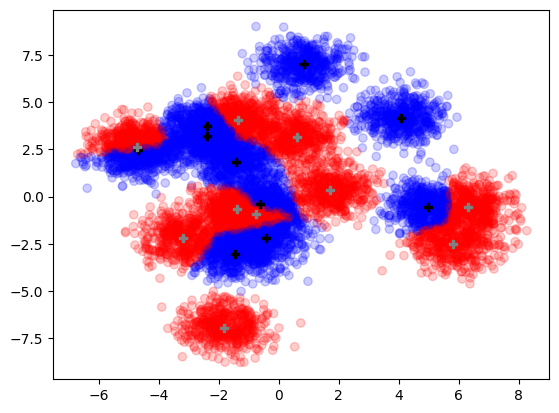

In [70]:
bayes_predictions = bayes_prob_predictions(centers0, centers1, test_samples, centers_covariance)

colors = ["red" if prediction else "blue" for prediction in bayes_predictions]
plt.scatter(test_samples[:, 0], test_samples[:, 1], alpha=0.2, c=colors)

plt.scatter(centers0[:, 0], centers0[:, 1], c="black", marker="P")
plt.scatter(centers1[:, 0], centers1[:, 1], c="gray", marker="P")

# Part 5: Simulation Study

In [71]:
num_simulations = 50

n = test_samples.shape[0]

knn_errors = np.zeros(num_simulations)
cvknn_errors = np.zeros(num_simulations)
bayes_errors = np.zeros(num_simulations)

for i in range(num_simulations):
    if i % 5 == 0:
        print("Iteration No.", i)
    
    new_train_samples, new_test_samples = generate_samples()
    test_labels = new_test_samples[:, 2]
    
    knn_predictions = kNN(new_train_samples, new_test_samples, 7)
    correct_predictions = np.sum(np.equal(test_labels, knn_predictions))
    knn_errors[i] = 1 - (correct_predictions / n)

    cv_knn_best_k = cv_knn(new_train_samples, 10)
    cvknn_predictions = kNN(new_train_samples, new_test_samples, cv_knn_best_k)
    correct_predictions = np.sum(np.equal(test_labels, cvknn_predictions))
    cvknn_errors[i] = 1 - (correct_predictions / n)

    bayes_predictions = bayes_prob_predictions(centers0, centers1, new_test_samples, centers_covariance)
    correct_predictions = np.sum(np.equal(test_labels, bayes_predictions))
    bayes_errors[i] = 1 - (correct_predictions / n)

Iteration No. 0
Iteration No. 5
Iteration No. 10
Iteration No. 15
Iteration No. 20
Iteration No. 25
Iteration No. 30
Iteration No. 35
Iteration No. 40
Iteration No. 45


In [72]:
def print_summary_statistics(model_name, min, max, first_q, second_q, third_q):
    print("#############")
    print(model_name, "Error Rate Summary Statistics")
    print("#############")
    print("Min: ", min)
    print("Max: ", max)
    print("25% Quantile: ", first_q)
    print("50% Quantile: ", second_q)
    print("75% Quantile: ", third_q)

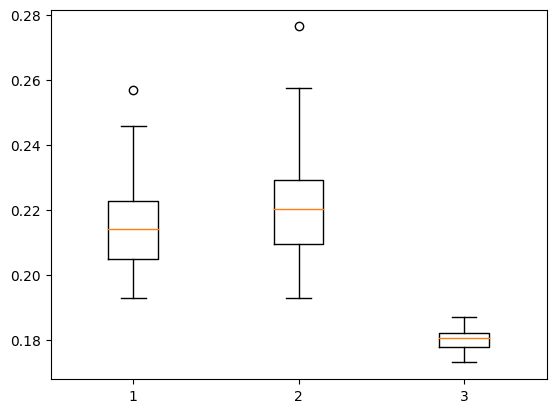

#############
7-NN Error Rate Summary Statistics
#############
Min:  0.19279999999999997
Max:  0.25670000000000004
25% Quantile:  0.20492500000000002
50% Quantile:  0.21395000000000003
75% Quantile:  0.222575
#############
K-NN (chosen by CV) Error Rate Summary Statistics
#############
Min:  0.19279999999999997
Max:  0.2764
25% Quantile:  0.20940000000000003
50% Quantile:  0.2202
75% Quantile:  0.22910000000000003
#############
Bayes Rule Error Rate Summary Statistics
#############
Min:  0.17300000000000004
Max:  0.18710000000000004
25% Quantile:  0.17772499999999997
50% Quantile:  0.18045
75% Quantile:  0.18207500000000004


In [73]:
plt.boxplot([knn_errors, cvknn_errors, bayes_errors])
plt.show()

print_summary_statistics("7-NN", np.min(knn_errors), np.max(knn_errors), 
                         np.quantile(knn_errors, 0.25), np.quantile(knn_errors, 0.5), 
                         np.quantile(knn_errors, 0.75))
print_summary_statistics("K-NN (chosen by CV)", np.min(cvknn_errors), np.max(cvknn_errors), 
                         np.quantile(cvknn_errors, 0.25), np.quantile(cvknn_errors, 0.5), 
                         np.quantile(cvknn_errors, 0.75))
print_summary_statistics("Bayes Rule", np.min(bayes_errors), np.max(bayes_errors), 
                         np.quantile(bayes_errors, 0.25), np.quantile(bayes_errors, 0.5), 
                         np.quantile(bayes_errors, 0.75))